In [51]:
import sys
#sys.path.append('/Users/Jake/opt/anaconda3/lib/python3.9/site-packages')
import math
import scipy as sp
#import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import random
import numpy as np
import cvxopt
#import pypoman
from scipy.stats import bernoulli, uniform, chi2
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from welford import Welford
from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, global_lower_bound,\
   intersection_mart, plot_marts_eta, construct_exhaustive_eta_grid, construct_eta_bands, brute_force_uits, selector,\
   construct_eta_grid_plurcomp, construct_vertex_etas, simulate_plurcomp, construct_eta_bands_plurcomp, random_truncated_gaussian,\
   PGD, convex_uits, stratified_t_test, banded_uits
np.random.seed(1337)

In [52]:
N = [20, 20]
A_c = [0.8, 0.8]
p_1 = [0.0, 0.0]
p_2 = [0.0, 0.0]
lam_func = Bets.agrapa 
allocation_func = Allocations.round_robin
method = "ui-ts"
WOR = False
reps = 1
n_bands = 100
alpha = 0.05

In [53]:
K = len(N)
u = 2 # the upper bound on the overstatment assorters, per STS
eta_0 = 1/2 # the global null in terms of the original assorters
assert K == 2, "only works for two strata"
w = N / np.sum(N)
assert np.dot(w, A_c) > 1/2, "reported assorter mean (A_c) implies the winner lost"
eta_1_grid = np.linspace(max(0, eta_0 - w[1]), min(u, eta_0/w[0]), n_bands + 1)
eta_2_grid = (eta_0 - w[0] * eta_1_grid) / w[1]
# transformed overstatement assorters
# the transofmration is per STS, except divided by 2
# the division by 2 allows a plurality CCA population to be defined on [0,1] instead of [0,2]
beta_1_grid = (eta_1_grid + 1 - A_c[0])/2 # transformed null means in stratum 1
beta_2_grid = (eta_2_grid + 1 - A_c[1])/2 # transformed null means in stratum 2
beta_grid = np.transpose(np.vstack((beta_1_grid, beta_2_grid)))
betas = []
for i in np.arange(beta_grid.shape[0]-1):
    centroid = (beta_grid[i,:] + beta_grid[i+1,:]) / 2
    betas.append([(beta_grid[i,:], beta_grid[i+1,:]), centroid])

In [54]:
construct_eta_bands_plurcomp(A_c, N, n_bands)

[[(array([0.1, 0.6]), array([0.105, 0.595])), array([0.1025, 0.5975])],
 [(array([0.105, 0.595]), array([0.11, 0.59])), array([0.1075, 0.5925])],
 [(array([0.11, 0.59]), array([0.115, 0.585])), array([0.1125, 0.5875])],
 [(array([0.115, 0.585]), array([0.12, 0.58])), array([0.1175, 0.5825])],
 [(array([0.12, 0.58]), array([0.125, 0.575])), array([0.1225, 0.5775])],
 [(array([0.125, 0.575]), array([0.13, 0.57])), array([0.1275, 0.5725])],
 [(array([0.13, 0.57]), array([0.135, 0.565])), array([0.1325, 0.5675])],
 [(array([0.135, 0.565]), array([0.14, 0.56])), array([0.1375, 0.5625])],
 [(array([0.14, 0.56]), array([0.145, 0.555])), array([0.1425, 0.5575])],
 [(array([0.145, 0.555]), array([0.15, 0.55])), array([0.1475, 0.5525])],
 [(array([0.15, 0.55]), array([0.155, 0.545])), array([0.1525, 0.5475])],
 [(array([0.155, 0.545]), array([0.16, 0.54])), array([0.1575, 0.5425])],
 [(array([0.16, 0.54]), array([0.165, 0.535])), array([0.1625, 0.5375])],
 [(array([0.165, 0.535]), array([0.17, 0

In [57]:
K = len(N)
w = N/np.sum(N)
A_c_global = np.dot(w, A_c)
betas = construct_eta_bands_plurcomp(A_c, N, n_bands)

x = []
v = 2 * A_c_global - 1 # global diluted margin
a = 1/(2-v) # where the pointmass would be for a global (unstratified) CCA

#construct assorter population within each stratum
for k in np.arange(K):
    num_points = [int(n_err) for n_err in saferound([N[k]*p_2[k], N[k]*p_1[k], N[k]*(1-p_2[k]-p_1[k])], places = 0)]
    x.append(1/2 * np.concatenate([np.zeros(num_points[0]), np.ones(num_points[1]) * 1/2, np.ones(num_points[2])]))

stopping_times = np.zeros(reps) #container for global stopping times
sample_sizes = np.zeros(reps) #container for global sample sizes
for r in np.arange(reps):
    X = [np.random.choice(x[k],  len(x[k]), replace = (not WOR)) for k in np.arange(K)] #shuffle (WOR) or sample (WR) a length-N_k sequence from each stratum k
    if method == "ui-ts":
        uits, eta_min, global_ss = banded_uits(X, N, betas, lam_func, allocation_func, log = True, WOR = WOR)
        stopping_times[r] = np.where(any(uits > -np.log(alpha)), np.argmax(uits > -np.log(alpha)), np.sum(N))
        sample_sizes[r] = global_ss[int(stopping_times[r])]
    elif method == "lcbs":
        eta_0 = (1/2 + 1 - A_c_global)/2
        lcb = global_lower_bound(X, N, lam_func, allocation_func, alpha, WOR = WOR, breaks = 1000)
        stopping_times[r] = np.where(any(lcb > eta_0), np.argmax(lcb > eta_0), np.sum(N))
        sample_sizes[r] = stopping_times[r]

In [60]:
stopping_times

array([12.])

In [4]:
%%time 
K = 50
N = [10 for _ in range(K)]
x_alt_1 = [random_truncated_gaussian(0.8, 0.05, N[k]) for k in range (K)]
convex_uits(x_alt_1, N, Allocations.round_robin, eta_0 = 0.5)[0]


CPU times: user 4min 19s, sys: 786 ms, total: 4min 19s
Wall time: 4min 20s


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   6.77488999,   6.7980811 ,
         6.81060786,   6.91051826,   6.95967668,   6.98888217,
         7.11072031,   7.22767984,   7.35661893,   7.52959959,
         7.65746987,   7.79257354,   7.95464298,   8.08

In [2]:
N = [10, 10, 10]
K = len(N)
x = [np.random.normal(0.5, 0.1, size = N[k]) for k in range(K)]
log = False
eta_0 = 0.5
allocation_func = Allocations.round_robin
w = N / np.sum(N) #stratum weights
n = [x[k].shape[0] for k in range(K)]


#this is a nested list of arrays
#it stores the samples available in each stratum at time i = 0,1,2,...,n
samples_t = [[[] for _ in range(K)] for _ in range(np.sum(n)+1)]
uinnsms = [0 if log else 1] #uinnsm starts at 1 at time 0
samples_t[0] = [np.array([]) for _ in range(K)] #initialize with no samples
T_k = np.zeros((np.sum(n)+1, K), dtype = int) #selections (including time 0)
bets_t = None
#constraint set for cvxopt
G = np.concatenate((
    np.expand_dims(w, axis = 0),
    np.expand_dims(-w, axis = 0),
    -np.identity(K),
    np.identity(K))
)
h = np.concatenate((
    eta_0 * np.ones(1),
    -eta_0 * np.ones(1),
    np.zeros(K),
    np.ones(K))
)

eta_stars = np.zeros((np.sum(n)+1, K))
eta_stars_start = pypoman.projection.project_point_to_polytope(point = np.ones(K), ineq = (G, h), qpsolver = 'cvxopt')
eta_stars[0,:] = eta_stars_start


for i in np.arange(1, np.sum(n)+1):
    #select next stratum
    S_i = allocation_func(x, T_k[i-1,:], n, N, eta = eta_stars[i-1,:], lam = bets_t)
    T_k[i,:] = T_k[i-1,:]
    T_k[i,S_i] += 1
    #bets for the stratum selection
    bets_t = [mart(x[k][0:T_k[i,k]], eta_stars[i-1,k], lam_func = Bets.inverse_eta, output = "bets") for k in range(K)]
    for k in np.arange(K):
        samples_t[i][k] = x[k][np.arange(T_k[i,k])] #update available samples
    #don't compute the minimum until there is a sample from each stratum
    if any(T_k[i,:] == 0):
        log_ts = 0
        eta_stars[i,:] = eta_stars_start
    else:
        SAMPLES = samples_t[i]
        #define function for cvxopt
        def F(x=None, z=None):
            x0 = cvxopt.matrix(eta_stars[i-1,:])
            if x is None and z is None:
                return 0, x0
            if z is None:
                return PGD.global_log_mart(x, SAMPLES), PGD.grad(x, SAMPLES).T
            return PGD.global_log_mart(x, SAMPLES), PGD.grad(x, SAMPLES).T, z*PGD.hessian(x, SAMPLES)
        soln = cvxopt.solvers.cp(F, cvxopt.matrix(G), cvxopt.matrix(h))
        if soln['status'] == 'optimal':
            eta_stars[i,:] = np.array(soln['x']).T
        else:
            raise RuntimeError("Optimization did not converge")
        #store current value of UI-TS
        log_ts = float(PGD.global_log_mart(eta_stars[i], SAMPLES)[0])
    if log:
        uinnsms.append(log_ts)
    else:
        uinnsms.append(np.exp(log_ts))

In [3]:
eta_stars

array([[0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ],
       [0.48054237, 0.57092301, 0.44853462],
       [0.58716656, 0.51035158, 0.40248186],
       [0.48826625, 0.67926373, 0.33247003],
       [0.45758416, 0.63467835, 0.40773748],
       [0.59904077, 0.54674871, 0.35421052],
       [0.53557341, 0.64664029, 0.3177863 ],
       [0.49193179, 0.59337988, 0.41468832],
       [0.56148323, 0.55165818, 0.38685859],
       [0.51568239, 0.62850557, 0.35581204],
       [0.48381641, 0.5887797 , 0.4274039 ],
       [0.53998241, 0.55561212, 0.40440547],
       [0.50369716, 0.61880377, 0.37749908],
       [0.47521463, 0.5826634 , 0.44212197],
       [0.50689188, 0.56434667, 0.42876147],
       [0.48795635, 0.59948746, 0.41255621],
       [0.46816108, 0.57434056, 0.45749836],
       [0.49975015, 0.5565101 , 0.44373975],
       [0.48420028, 0.58607996, 0.42971976],
       [0.46701685, 0.56460053, 0.46838263],
       [0.

In [3]:
print(F(x = [0.0001, 0.9999], z = 0.1)[2])

[ 2.00e+07  0.00e+00]
[ 0.00e+00  2.92e-02]



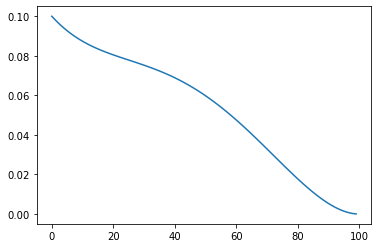

In [60]:
#negative exponential bets are not necessarily convex unless a = 1
a = 1
b = 1
etas = np.arange(0,1,.01)
x = np.ones(10) * 0.5
mart = []
for eta in etas:
    eta_1 = eta
    eta_2 = 1 - eta
    mart.append((1 + np.exp(a - b * eta_1) * (0 - eta_1)) * (1 + np.exp(a - b * eta_2) * (0.1 - eta_2)))
plt.plot(np.array(mart))

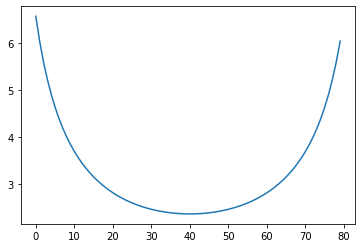

In [47]:
#inverse bets
c = 0.9
etas = np.arange(0.1,0.9,.01)
x = np.ones(10) * 0.5
mart = []
for eta in etas:
    eta_1 = eta
    eta_2 = 1 - eta
    mart.append((1 + (c/eta_1) * (0.8 - eta_1)) * (1 + (c/eta_2) * (0.8 - eta_2)))
plt.plot(np.array(mart))

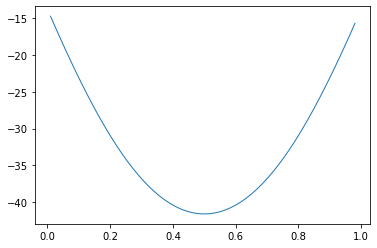

In [69]:
lam_func = Bets.negative_exponential
def lam_func(x, eta):
    return np.exp(1 - 2*eta)
allocation_func = Allocations.round_robin
mixing_dist = None
combine = "product"
theta_func = None
log = True

N = [30,30]
x = [np.random.normal(0.5, 0.1, N[0]), np.random.normal(0.5, 0.1, N[0])]
x = [np.ones(N[0]) * 0, np.ones(N[0]) * 0]

eta_grid = np.arange(range[0] + res, range[1]-res, step=res)
eta_xs, eta_ys, eta_zs, objs = [], [], [], []
w = N / np.sum(N)
for eta_x in eta_grid:
    eta_y = (1/2 - w[0] * eta_x) / w[1]
    if eta_y > 1 or eta_x < 0: continue
    obj = intersection_mart(x = x, N = N, eta = np.array([eta_x,eta_y]), lam_func = lam_func,
     lam = None, mixing_dist = mixing_dist, allocation_func = allocation_func,
     combine = combine, theta_func = theta_func, log = log, running_max = False)[-1]
    eta_xs.append(eta_x)
    eta_ys.append(eta_y)
    objs.append(obj)
min_ix = np.argmin(objs)
min_eta = np.round([eta_xs[min_ix], eta_ys[min_ix]], 2)
plt.plot(eta_xs, objs, linewidth = 1)
plt.show()

In [3]:
x = np.array([0,1,0.5,0.6, 0.6, 0.6, 0.6])
sd_min = 0.01
c = 0.9
eta = 0.5
eps = 1e-5
w = Welford()
mu_hat = []
sd_hat = []
for x_i in x:
    w.add(x_i)
    mu_hat.append(float(w.mean))
    sd_hat.append(np.sqrt(w.var_s))
sd_hat[0] = 1/4
lag_mu_hat = np.insert(mu_hat, 0, 1/2)[0:-1]
lag_sd_hat = np.insert(np.maximum(sd_hat, sd_min), 0, 1/4)[0:-1]

lam_untrunc = (lag_mu_hat - eta) / (lag_sd_hat**2 + (lag_mu_hat - eta)**2)
#this rule says to bet the farm when eta is 0 (can't possibly lose)
lam_trunc = np.maximum(0, np.where(eta > 0, np.minimum(lam_untrunc, c/(eta+eps)), np.inf))

In [58]:
K = 2
w = [1/2, 1/2]
N = np.array([500, 500])
eta_0 = 1/2
eta_bands = construct_eta_bands(eta_0, N = w, n_bands = 100)
global_mean = 0.65
#deltas = [0.25, -0.25]
deltas = [0, 0]
sd = 0.05
x = [np.random.binomial(1, global_mean + deltas[k], N[k]) for k in range(K)]

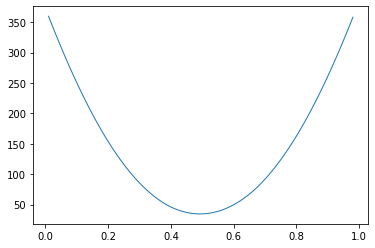

minimum eta = [0.49 0.51]
minimum = 34.69900040249988
stopping time = 120


In [59]:
lam = lambda x, eta: Bets.negative_exponential(x, eta, c = 1)
ui_mart, min_etas, global_ss = banded_uits(
                            x = x,
                            N = N,
                            etas = eta_bands,
                            lam_func = lam,
                            allocation_func = Allocations.round_robin,
                            log = True,
                            WOR = False)
#eps = lambda x, eta: Bets.negative_exponential(x, eta, c = )
#lam = lambda x, eta: Bets.inverse_eta(x, eta, c = 0.5)
plot_marts_eta(x, N, lam_func = lam, log = True)
print("stopping time = " + str(np.argmax(ui_mart > np.log(1/0.05))))

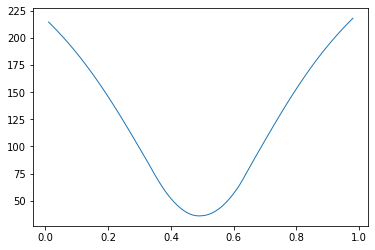

minimum eta = [0.49 0.51]
minimum = 35.99008036533107
stopping time = 148


In [60]:
lam = lambda x, eta: Bets.agrapa(x, eta) 
ui_mart, min_etas, global_ss = banded_uits(
                            x = x,
                            N = N,
                            etas = eta_bands,
                            lam_func = lam,
                            allocation_func = Allocations.round_robin,
                            log = True,
                            WOR = False)
plot_marts_eta(x, N, lam_func = lam, log = True)
print("stopping time = " + str(np.argmax(ui_mart > np.log(1/0.05))))

In [172]:
%%time
rep_grid = np.arange(1) #allows reps within parallelized simulations
sim_id = str(2)
np.random.seed(int(sim_id)) #this sets a different seed for every rep


#alt_grid = np.linspace(0.51, 0.7, 20)
alt_grid = [0.65]
delta_grid = [0.5]
alpha = 0.05
eta_0 = 0.5

methods_list = ['uinnsm_product','lcb']
bets_dict = {
    "fixed_plugin": Bets.predictable_plugin,
    "agrapa":lambda x, eta: Bets.agrapa(x, eta, c = 0.75),
    "bernoulli":lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.75),
    "smooth_predictable":lambda x, eta: Bets.negative_exponential(x, eta, c = 0.95)}
bets_list = ["smooth_predictable"]
allocations_dict = {
    "round_robin":Allocations.round_robin,
    "predictable_kelly":Allocations.predictable_kelly,
    "greedy_kelly":Allocations.greedy_kelly}
#allocations_list = ["round_robin", "predictable_kelly", "greedy_kelly"]
allocations_list = ["round_robin"]

K = 2
w = [1/2, 1/2]
N = np.array([100, 100]) #size of initial sample
N_next = np.array([200, 200]) #size of blocks at which sample will expand
N_max = np.array([2100, 2100]) #maximum size
results = []
eta_bands = construct_eta_bands(eta_0, N = w, n_bands = 100)

for alt, delta, rep in itertools.product(alt_grid, delta_grid, rep_grid):
    print(str(alt))
    sim_rep = sim_id + "_" + str(rep)
    means = [alt - 0.5*delta, alt + 0.5*delta]
    samples = [np.random.binomial(1, means[k], N[k]) for k in range(K)]
    #ap bernoulli is based on the true means
    bets_dict["apriori_bernoulli"] = [
        lambda x, eta: Bets.apriori_bernoulli(x, eta, mu_0 = means[0]),
        lambda x, eta: Bets.apriori_bernoulli(x, eta, mu_0 = means[1])]
    for method, bet, allocation in itertools.product(methods_list, bets_list, allocations_list):
        if method == 'lcb':
            min_eta = None
            if allocation in ['proportional_to_mart','predictable_kelly','greedy_kelly']:
                stopping_time = None
                sample_size = None
            else:
                done = False
                while not done:
                    lower_bound = global_lower_bound(
                        x = samples,
                        N = N,
                        lam_func = bets_dict[bet],
                        allocation_func = allocations_dict[allocation],
                        alpha = alpha,
                        breaks = 1000,
                        WOR = False)
                    if any(lower_bound > eta_0):
                        sample_size = stopping_time = np.argmax(lower_bound > eta_0)
                        done = True
                    elif any(N >= N_max):
                        sample_size = stopping_time = np.sum(N)-1
                        done = True
                    else:
                        for k in range(K):
                            samples[k] = np.append(samples[k], np.random.binomial(1, means[k], N_next[k]))
                        N = N + N_next
        elif method == 'uinnsm_product':
            done = False
            while not done:
                ui_mart, min_etas, global_ss = banded_uits(
                            x = samples,
                            N = N,
                            etas = eta_bands,
                            lam_func = bets_dict[bet],
                            allocation_func = allocations_dict[allocation],
                            log = True,
                            WOR = False)
                if any(ui_mart > np.log(1/alpha)):
                    stopping_time = np.argmax(ui_mart > np.log(1/alpha))
                    min_eta = min_etas[stopping_time]
                    sample_size = global_ss[stopping_time]
                    done = True
                elif any(N >= N_max):
                    stopping_time = np.sum(N)-1
                    min_eta = min_etas[stopping_time]
                    sample_size = global_ss[stopping_time]
                    done = True
                else:
                    for k in range(K):
                        samples[k] = np.append(samples[k], np.random.binomial(1, means[k], N_next[k]))
                    N = N + N_next
        data_dict = {
            "alt":alt,
            "rep":sim_rep,
            "delta":delta,
            "method":str(method),
            "bet":str(bet),
            "allocation":str(allocation),
            "stopping_time":stopping_time,
            "sample_size":sample_size,
            "worst_case_eta":min_eta}
        results.append(data_dict)
results = pd.DataFrame(results)

0.65


/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:231: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - np.log(eps)) / lag_mu_hat
/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:232: RuntimeWarning: invalid value encountered in multiply
  lam = np.exp(1 - b * eta)


CPU times: user 2.92 s, sys: 19.1 ms, total: 2.94 s
Wall time: 2.93 s


In [173]:
res = banded_uits(x = samples,
                    N = N,
                    etas = eta_bands,
                    lam_func = bets_dict[bet],
                    allocation_func = allocations_dict[allocation],
                    log = True,
                    WOR = False, verbose = True)

/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:231: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - np.log(eps)) / lag_mu_hat


In [174]:
obj = res[3]

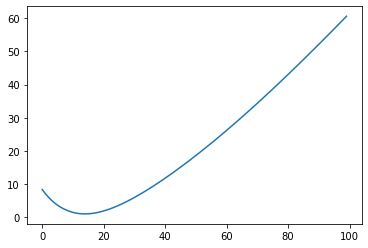

In [176]:
plt.plot(obj[:,100])

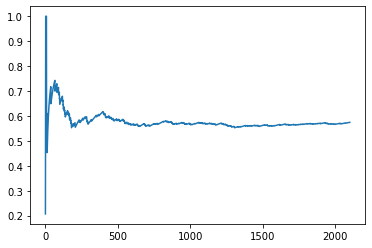

In [86]:
plt.plot(res[5][0][1])

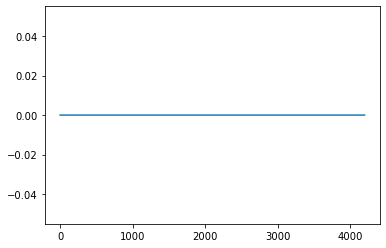

In [81]:
plt.plot(obj[0,:])

In [91]:
res[5][0]

[array([2.64916993, 0.        , 0.        , ..., 2.59999033, 2.60007227,
        2.60015402]),
 array([0.20693219, 0.75      , 1.        , ..., 0.57410045, 0.57421668,
        0.57433282])]

In [155]:
eta_bands[0]

[(array([0., 1.]), array([0.01, 0.99])), array([0.005, 0.995])]

In [156]:
etas = eta_bands
i = 0
lam_func = [bets_dict["smooth_predictable"], bets_dict["smooth_predictable"]]
log = True
ws_N = np.inf * np.ones(2)
N = N_max
bets = []
x = samples
allocation_func = Allocations.round_robin
n = [x_k.shape[0] for x_k in x]
WOR = False
obj = np.zeros((len(etas), np.sum(n) + 1))
sel = np.zeros((len(etas), np.sum(n) + 1, K))
min_etas = []
bets = []


centroid_eta = etas[i][1]
max_eta = np.max(np.vstack(etas[i][0]),0) #record largest eta in the band for each stratum
#bets are determined for max_eta, which makes the bets conservative for both strata and both vertices of the band
bets_i = [mart(x[k], max_eta[k], lam_func[k], None, ws_N[k], log, output = "bets") for k in np.arange(K)]
bets.append(bets_i)
#selections are determined by the centroid
T_k_i = selector(x, N, allocation_func, centroid_eta, bets_i)
itsm_mat = np.zeros((np.sum(n)+1, 2))
#minima are evaluated at the endpoints of the band//
#one of which is the minimum over the whole band due to concavity
for j in np.arange(2):
    itsm_mat[:,j] = intersection_mart(x = x, N = N, eta = etas[i][0][j], lam = bets_i, T_k = T_k_i,
        combine = "product", log = log, WOR = WOR)
obj[i,:] = np.min(itsm_mat, 1)
sel[i,:,:] = T_k_i

In [157]:
bets_i

[array([2.64916993, 0.        , 0.        , ..., 2.59999033, 2.60007227,
        2.60015402]),
 array([0.20693219, 0.75      , 1.        , ..., 0.57410045, 0.57421668,
        0.57433282])]

In [158]:
intersection_mart(x = x, N = N, eta = etas[i][0][0], lam = bets_i, T_k = T_k_i,
        combine = "product", log = log, WOR = WOR)

array([0., 0., 0., ..., 0., 0., 0.])

In [159]:
eta = etas[i][0][0]
lam = bets_i
T_k = T_k_i
ws_log = True
last = False

if lam is None:
    lam = [mart(x[k], eta[k], lam_func[k], None, ws_N[k], ws_log, output = "bets") for k in np.arange(K)]
#within-stratum martingales
ws_marts = [mart(x[k], eta[k], None, lam[k], ws_N[k], ws_log) for k in np.arange(K)]
#construct the interleaving
if T_k is None:
    T_k = selector(x, N, allocation_func, eta, lam)
if last:
    marts = np.array([[ws_marts[k][T_k[-1, k]] for k in np.arange(K)]])
    if np.any(np.isposinf(marts)):
        #it's not exactly clear how to handle certainties when sampling without replacement
        #i.e. what if the null is certainly false in one stratum but certainly true in another...
        marts = np.inf * np.ones((1,K))
else:
    marts = np.zeros((T_k.shape[0], K))
    for i in np.arange(T_k.shape[0]):
        marts_i = np.array([ws_marts[k][T_k[i, k]] for k in np.arange(K)])
        #make all marts infinite if one is, when product is taken this enforces rule:
        #we reject intersection null if certainly False in one stratum
        #TODO: rethink this logic? What if the null is certainly true in a stratum?
        #there is some serious subtlety to be considered when sampling WOR
        marts[i,:] = marts_i if not any(np.isposinf(marts_i)) else np.inf * np.ones(K)

In [171]:
bets_i[1][0:30]

array([0.20693219, 0.75      , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.52653086, 0.55925583,
       0.58656122, 0.60974163, 0.45308296, 0.47793199, 0.50004028,
       0.51984731, 0.53770502, 0.55389774, 0.56865717, 0.58217386,
       0.59460579, 0.60608501, 0.61672272, 0.62661323, 0.63583705,
       0.6444633 , 0.65255171, 0.66015414, 0.66731586, 0.67407655])

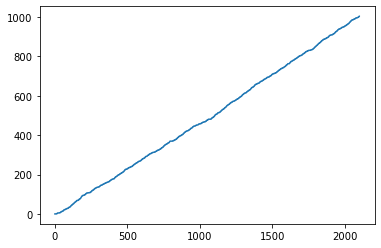

In [141]:
plt.plot(mart(x[0], eta[0], None, lam[0], ws_N[0], ws_log))

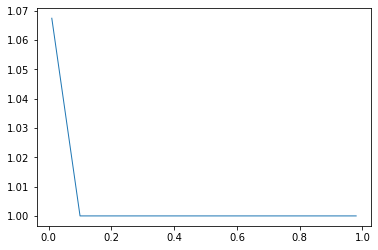

minimum eta = [0.1 0.9]
minimum = 1.0


In [23]:
N = [20, 20]
x = [0.1 * np.ones(N[0]), 0.5 * np.ones(N[1])]
#lam = lambda x, eta: Bets.negative_exponential(x, eta, a = 1, b = 1)
lam = lambda x, eta: Bets.fixed(x, eta)
plot_marts_eta(x, N, lam_func = lam, log = False)

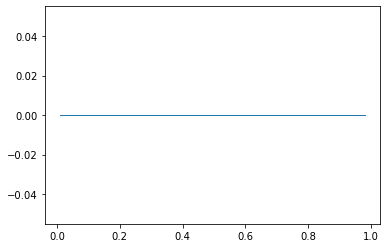

In [11]:
lam_func = lam
allocation_func = Allocations.round_robin
mixing_dist = None
combine = "product"
theta_func = None
res = 0.01
range = [0,1]
log = True

eta_grid = np.arange(range[0] + res, range[1]-res, step=res)
eta_xs, eta_ys, eta_zs, objs = [], [], [], []
w = N / np.sum(N)
for eta_x in eta_grid:
    eta_y = (1/2 - w[0] * eta_x) / w[1]
    if eta_y > 1 or eta_x < 0: continue
    obj = intersection_mart(x = x, N = N, eta = np.array([eta_x,eta_y]), lam_func = lam_func,
     lam = None, mixing_dist = mixing_dist, allocation_func = allocation_func,
     combine = combine, theta_func = theta_func, log = log)[-1]
    eta_xs.append(eta_x)
    eta_ys.append(eta_y)
    objs.append(obj)
min_ix = np.argmin(objs)
min_eta = np.round([eta_xs[min_ix], eta_ys[min_ix]], 2)
plt.plot(eta_xs, objs, linewidth = 1)
plt.show()

In [13]:
eta_y

0.020000000000000018